In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
import time

from tqdm import trange
from IPython.display import clear_output
from gym.core import ObservationWrapper
from keras.layers import Conv2D, Dense, Flatten
from keras.initializers import RandomUniform
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Lambda, GaussianNoise, concatenate

tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

%matplotlib inline
np.warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# replay class that stores n size tuple of experiences
class ExpReplay(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size       

    def __len__(self):
        return len(self._storage)

    def add(self, s, a, r, next_s, done):
        data = (s, a, r, next_s, done)
        
        self._storage.append(data)
        storage_size = len(self._storage)
        if (storage_size >= self._maxsize):
            self._storage = self._storage[storage_size-self._maxsize:]
        
    def sample(self, batch_size):
        idx = np.random.randint(0, len(self._storage), size=batch_size)
        batch = np.array(self._storage)[idx]
        states, actions, rewards, next_states, isdone = [], [], [], [], []
        
        for s, a, r, ns, done in batch:
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(ns)
            isdone.append(done)
        
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(isdone)

In [11]:
#inspired by: https://github.com/germain-hug/Deep-RL-Keras
# and OpenAI spinningup

class actor:
    
    def __init__(self, state_dim, action_dim, act_limit, tau = 0.995):
        
        self.state_dim = state_dim
        self.action_n = action_dim[0]
        self.act_limit = act_limit
        self.tau = tau
        self.model = self.create_network(self.state_dim, self.action_n)
        self.target_model = self.create_network(self.state_dim, self.action_n)
        
    def create_network(self, state_dim, action_dim):
        
        state_input = Input((self.state_dim))
        x = Dense(400, activation='relu')(state_input)
        x = GaussianNoise(1.0)(x)
        
        x = Dense(300, activation='relu')(x)
        x = GaussianNoise(1.0)(x)
        
        out = Dense(self.action_n, activation='tanh' ,kernel_initializer=RandomUniform())(x)
        out = Lambda(lambda i: i * self.act_limit)(out)

        return Model(state_input, out)
        
    def get_action(self, state, noise = 0.1):
        
        if len(state.shape) == 1:
            state = state[None]
            
        a = self.model.predict(state)
        a += noise * np.random.randn(self.action_n)
        
        return np.clip(a, -self.act_limit, self.act_limit)[0]
       
    def transfer_weights(self):

        W, target_W = self.model.get_weights(), self.target_model.get_weights()
        for i in range(len(W)):
            target_W[i] = self.tau * W[i] + (1 - self.tau)* target_W[i]
        self.target_model.set_weights(target_W)
    
            
class critic:
    
    def __init__(self, state_dim, action_dim, tau = 0.99):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.tau = tau
        self.model = self.create_network(self.state_dim, self.action_dim)
        self.target_model = self.create_network(self.state_dim, self.action_dim)
        
    def create_network(self, state_dim, action_dim):
        
        state = Input((self.state_dim))
        action = Input((self.action_dim))
        
        x = concatenate([state, action])
        x = Dense(400, activation='relu')(x)      
        x = Dense(128, activation='relu')(x)
        out = Dense(1, activation='linear')(x)
        
        return Model([state, action], out)
           
    def transfer_weights(self):

        W, target_W = self.model.get_weights(), self.target_model.get_weights()
        for i in range(len(W)):
            target_W[i] = self.tau * W[i] + (1 - self.tau)* target_W[i]
        self.target_model.set_weights(target_W)


class DDPG(object):
    
    def __init__(self, state_dim
                     ,action_dim
                     ,act_limit
                     ,tau = 0.995
                     ,gamma = 0.99
                     ,critic_lr = 1e-4
                     ,actor_lr = 1e-4
                     ,batch_size = 100
                     ,act_noise=0.1
                     ,max_ep_len=1000):
        
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.tau = tau
        self.gamma = gamma
        self.batch_size = batch_size
        self.act_noise = act_noise
        self.max_ep_len = max_ep_len
        self.act_limit = act_limit
        
        self.obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
        self.actions_ph = tf.placeholder(tf.float32, shape=(None,) + action_dim)
        self.rewards_ph = tf.placeholder(tf.float32, shape=[None])
        self.next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
        self.is_done_ph = tf.placeholder(tf.float32, shape=[None])
        self.is_not_done = 1 - self.is_done_ph
        
        self.actor_agent = actor(state_dim = self.state_dim, action_dim = self.action_dim, act_limit = env.action_space.high[0])
        self.critic_agent = critic(state_dim = self.state_dim, action_dim = self.action_dim)
        
        #critic update
        target = self.critic_agent.target_model([self.next_obs_ph, self.actor_agent.target_model(self.next_obs_ph)])
        target_qsa = self.rewards_ph + (self.gamma * tf.multiply(target, self.is_not_done))
        qsa = self.critic_agent.model([self.obs_ph, self.actions_ph])
        
        self.critic_loss = tf.reduce_mean((qsa - target_qsa)**2)        
        self.train_q_op = tf.train.AdamOptimizer(critic_lr).minimize(self.critic_loss, var_list = self.critic_agent.model.weights)
        
        #actor update
        current_qsa = self.critic_agent.model([self.obs_ph, self.actor_agent.model(self.obs_ph)])
        self.actor_loss = -tf.reduce_mean(current_qsa)
        self.train_act = tf.train.AdamOptimizer(actor_lr).minimize(self.actor_loss, var_list = self.actor_agent.model.weights)
                      
        sess.run(tf.global_variables_initializer())
        
    def test_agent(self, test_env, n = 3):
        total_rewards = []
        
        for j in range(n):
            s, r, d, ep_ret, ep_len = test_env.reset(), 0, False, 0, 0
            while not(d or (ep_len == self.max_ep_len)):
                # Take deterministic actions at test time (noise_scale=0)
                next_s, r, d, _ = test_env.step(self.actor_agent.get_action(s, 0))
                ep_ret += r
                ep_len += 1
                
                s = next_s
            total_rewards.append(ep_ret)
        
        test_env.reset()
        return np.mean(total_rewards)
        
    def train_agent(self, env, total_steps, replay_buffer, start_steps=10000):
        
        mean_test_rw = []
        loss_actor = []
        loss_critic = []
        ep_ret_history = []
        
        s, r, done, ep_ret, ep_len = env.reset(), 0, False, 0, 0
        
        for t in range(total_steps):
            
            if t > start_steps:
                a = self.actor_agent.get_action(s, 1)
            else:
                a = env.action_space.sample()

            next_s, r, done, _ = env.step(a)
            ep_ret += r
            ep_len += 1

            done = False if ep_len==self.max_ep_len else done

            # Store experience to replay buffer
            replay_buffer.add(s, a, r, next_s, done)

            s = next_s

            if done or (ep_len == self.max_ep_len):

                ep_ret_history.append(ep_ret)
                
                for _ in range(ep_len):
                    states, actions, rewards, next_states, done = replay_buffer.sample(self.batch_size)
                    feed_dict = {
                                 self.obs_ph: states,
                                 self.actions_ph: actions,
                                 self.rewards_ph: rewards,
                                 self.next_obs_ph: next_states,
                                 self.is_done_ph: done
                                }

                    # update
                    _, _, act_loss, cri_loss = sess.run([self.train_act, self.train_q_op, self.actor_loss, self.critic_loss], feed_dict)
                    loss_actor.append(act_loss)
                    loss_critic.append(cri_loss)

                    self.actor_agent.transfer_weights()
                    self.critic_agent.transfer_weights()

                s, r, done, ep_ret, ep_len = env.reset(), 0, False, 0, 0

                # Test the performance of the deterministic version of the agent.
                test_env = env
                mean_test_rw.append(self.test_agent(test_env))
                
                plt.figure(figsize=[24, 4])
                clear_output(True)

                plt.subplot(1, 4, 1)
                plt.plot(mean_test_rw)
                plt.title('mean test reward')

                plt.subplot(1, 4, 2)
                plt.plot(loss_actor)
                plt.title('actor loss')

                plt.subplot(1, 4, 3)
                plt.plot(loss_critic)
                plt.title('critic loss')

                plt.subplot(1, 4, 4)
                plt.plot(ep_ret_history)
                plt.title('train rewards')

                plt.show()
                print(t)


In [12]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

#env = gym.make('BipedalWalker-v2')
env = gym.make('MountainCarContinuous-v0')
s = env.reset()

action_dim = env.action_space.shape
state_dim = env.observation_space.shape

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [13]:
ddpg = DDPG(state_dim = state_dim, action_dim = action_dim, act_limit = env.action_space.high[0])
replaybuffer = ExpReplay(1e6)

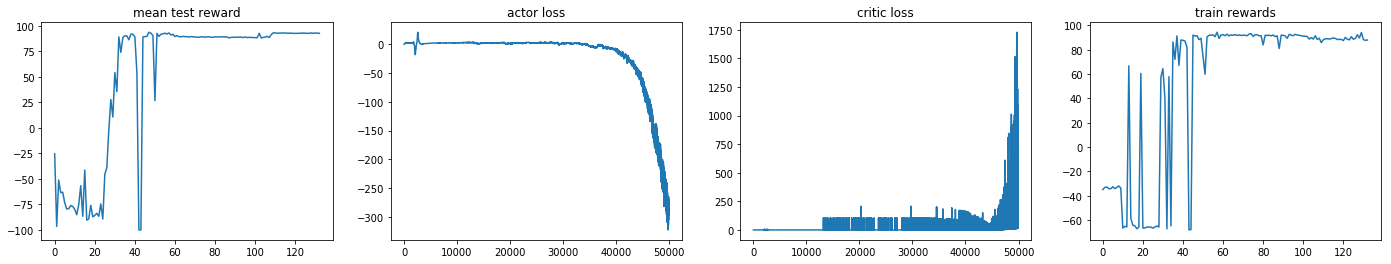

49917


In [14]:
ddpg.train_agent(env, 5000 * 10, replaybuffer)

In [35]:
#test
ddpg.test_agent(env)

92.6558060054187